Built 50 trees for subset size 2
Built 100 trees for subset size 2
Built 150 trees for subset size 2
Built 200 trees for subset size 2
Built 250 trees for subset size 2
Built 300 trees for subset size 2
Built 350 trees for subset size 2
Built 400 trees for subset size 2
Built 450 trees for subset size 2
Built 500 trees for subset size 2
Completed Random Forest with subset size 2
Built 50 trees for subset size 4
Built 100 trees for subset size 4
Built 150 trees for subset size 4
Built 200 trees for subset size 4
Built 250 trees for subset size 4
Built 300 trees for subset size 4
Built 350 trees for subset size 4
Built 400 trees for subset size 4
Built 450 trees for subset size 4
Built 500 trees for subset size 4
Completed Random Forest with subset size 4
Built 50 trees for subset size 6
Built 100 trees for subset size 6
Built 150 trees for subset size 6
Built 200 trees for subset size 6
Built 250 trees for subset size 6
Built 300 trees for subset size 6
Built 350 trees for subset size 6

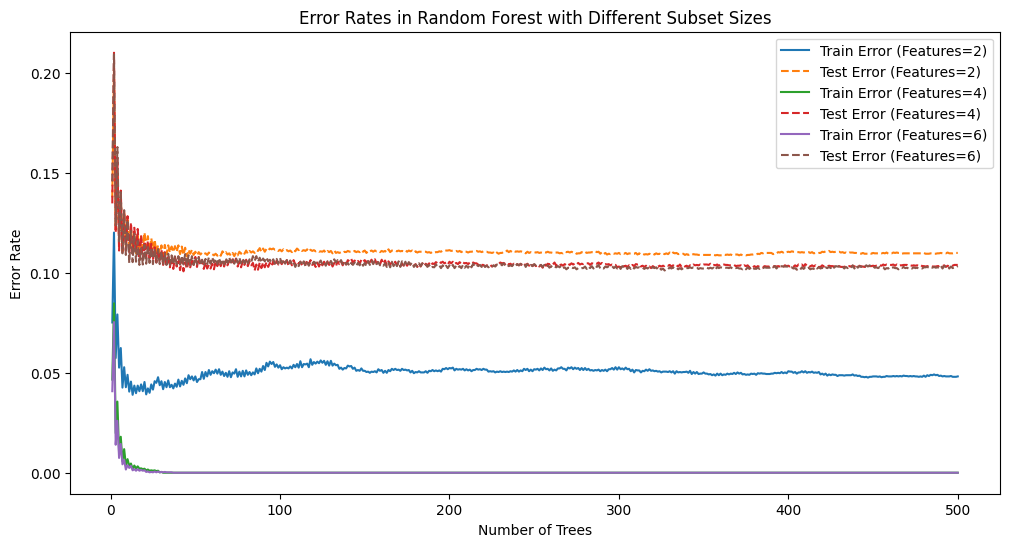

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

def create_tree_node(output=None):
    return {'output': output, 'left_child': None, 'right_child': None, 'split_feature': None, 'split_value': None}

def is_terminal_node(node):
    return node['output'] is not None

def identify_feature_types(feature_data):
    types_of_features = []
    for i in range(feature_data.shape[1]):
        unique_values = np.unique(feature_data[:, i])
        if isinstance(unique_values[0], (int, float)) and len(unique_values) > 10:
            types_of_features.append("continuous")
        else:
            types_of_features.append("discrete")
    return types_of_features

def divide_data(feature_data, feature_idx, value):
    left_partition = np.where(feature_data[:, feature_idx] <= value)[0]
    right_partition = np.where(feature_data[:, feature_idx] > value)[0]
    return left_partition, right_partition

def calculate_uncertainty(label_data):
    label_count = Counter(label_data)
    total_count = len(label_data)
    uncertainty_score = 0.0
    for count in label_count.values():
        probability = count / total_count
        if probability > 0:
            uncertainty_score -= probability * np.log2(probability)
    return uncertainty_score

def gain_from_split(y_values, left_y_values, right_y_values):
    total_samples = len(y_values)
    parent_uncertainty = calculate_uncertainty(y_values)
    left_uncertainty = calculate_uncertainty(left_y_values)
    right_uncertainty = calculate_uncertainty(right_y_values)
    weighted_child_uncertainty = (len(left_y_values) / total_samples) * left_uncertainty + (len(right_y_values) / total_samples) * right_uncertainty
    return parent_uncertainty - weighted_child_uncertainty

def find_best_split(data_matrix, labels, feature_type_list, max_feature_size, threshold_options=5):
    highest_gain = -np.inf
    best_feature_idx = None
    best_split_value = None

    selected_features = np.random.choice(data_matrix.shape[1], max_feature_size, replace=False)

    for feature in selected_features:
        if feature_type_list[feature] == "continuous":
            unique_vals = np.unique(data_matrix[:, feature])
            if len(unique_vals) > threshold_options:
                thresholds = np.quantile(unique_vals, np.linspace(0, 1, threshold_options + 2)[1:-1])
            else:
                thresholds = unique_vals

            for split_val in thresholds:
                left_subset, right_subset = divide_data(data_matrix, feature, split_val)
                if len(left_subset) == 0 or len(right_subset) == 0:
                    continue
                gain = gain_from_split(labels, labels[left_subset], labels[right_subset])
                if gain > highest_gain:
                    highest_gain = gain
                    best_feature_idx = feature
                    best_split_value = split_val
        else:
            unique_vals = np.unique(data_matrix[:, feature])
            for val in unique_vals:
                left_subset, right_subset = divide_data(data_matrix, feature, val)
                if len(left_subset) == 0 or len(right_subset) == 0:
                    continue
                gain = gain_from_split(labels, labels[left_subset], labels[right_subset])
                if gain > highest_gain:
                    highest_gain = gain
                    best_feature_idx = feature
                    best_split_value = val

    return best_feature_idx, best_split_value

def construct_tree(data_matrix, labels, feature_type_list, max_feature_size):
    if len(np.unique(labels)) == 1:
        return create_tree_node(output=labels[0])

    optimal_feature, split_val = find_best_split(data_matrix, labels, feature_type_list, max_feature_size)

    if optimal_feature is None:
        return create_tree_node(output=Counter(labels).most_common(1)[0][0])

    left_subset, right_subset = divide_data(data_matrix, optimal_feature, split_val)

    if len(left_subset) == 0 or len(right_subset) == 0:
        return create_tree_node(output=Counter(labels).most_common(1)[0][0])

    left_branch = construct_tree(data_matrix[left_subset], labels[left_subset], feature_type_list, max_feature_size)
    right_branch = construct_tree(data_matrix[right_subset], labels[right_subset], feature_type_list, max_feature_size)

    node = create_tree_node()
    node['split_feature'] = optimal_feature
    node['split_value'] = split_val
    node['left_child'] = left_branch
    node['right_child'] = right_branch

    return node

def generate_tree_predictions(data_matrix, decision_tree):
    predictions = np.zeros(data_matrix.shape[0])
    for i, sample in enumerate(data_matrix):
        current_node = decision_tree
        while not is_terminal_node(current_node):
            if sample[current_node['split_feature']] <= current_node['split_value']:
                current_node = current_node['left_child']
            else:
                current_node = current_node['right_child']
        predictions[i] = current_node['output']
    return predictions

def random_forest_algorithm(train_X, train_y, test_X, test_y, num_trees=500, subset_feature_sizes=[2, 4, 6], data_sample_ratio=0.7):
    performance_results = {size: {'train_error_rates': [], 'test_error_rates': []} for size in subset_feature_sizes}

    for subset_size in subset_feature_sizes:
        train_errors = []
        test_errors = []
        cumulative_train_predictions = np.zeros(train_X.shape[0])
        cumulative_test_predictions = np.zeros(test_X.shape[0])

        for i in range(num_trees):
            sampled_indices = np.random.choice(train_X.shape[0], int(data_sample_ratio * train_X.shape[0]), replace=False)
            X_subset = train_X[sampled_indices]
            y_subset = train_y[sampled_indices]

            tree_model = construct_tree(X_subset, y_subset, identify_feature_types(X_subset), subset_size)

            single_train_predictions = generate_tree_predictions(train_X, tree_model)
            single_test_predictions = generate_tree_predictions(test_X, tree_model)

            cumulative_train_predictions += single_train_predictions
            cumulative_test_predictions += single_test_predictions

            final_train_predictions = np.sign(cumulative_train_predictions)
            final_test_predictions = np.sign(cumulative_test_predictions)

            train_error = np.mean(train_y != final_train_predictions)
            test_error = np.mean(test_y != final_test_predictions)

            train_errors.append(train_error)
            test_errors.append(test_error)

            if (i + 1) % 50 == 0 or i == num_trees - 1:
                print(f"Built {i + 1} trees for subset size {subset_size}")

        performance_results[subset_size]['train_error_rates'] = train_errors
        performance_results[subset_size]['test_error_rates'] = test_errors

        print(f"Completed Random Forest with subset size {subset_size}")

    plt.figure(figsize=(12, 6))
    for subset_size in subset_feature_sizes:
        plt.plot(range(1, num_trees + 1), performance_results[subset_size]['train_error_rates'], label=f'Train Error (Features={subset_size})')
        plt.plot(range(1, num_trees + 1), performance_results[subset_size]['test_error_rates'], label=f'Test Error (Features={subset_size})', linestyle='--')
    plt.xlabel('Number of Trees')
    plt.ylabel('Error Rate')
    plt.title('Error Rates in Random Forest with Different Subset Sizes')
    plt.legend()
    plt.show()

def process_data(dataset):
    categorical_columns = dataset.select_dtypes(include=['object']).columns
    for column in categorical_columns:
        dataset[column] = pd.Categorical(dataset[column]).codes
    return dataset

def execute():
    column_names = ['age', 'job', 'marital_status', 'education', 'default_status', 'account_balance',
                    'has_housing_loan', 'has_personal_loan', 'contact_type', 'day_of_contact', 'month_of_contact', 'call_duration',
                    'campaign_number', 'days_passed', 'prev_campaign', 'outcome', 'target_label']

    train_dataset = pd.read_csv("train.csv", names=column_names)
    test_dataset = pd.read_csv("test.csv", names=column_names)

    train_dataset = process_data(train_dataset)
    test_dataset = process_data(test_dataset)

    features_train = train_dataset.drop('target_label', axis=1).values
    labels_train = np.where(train_dataset['target_label'] == 1, 1, -1)
    features_test = test_dataset.drop('target_label', axis=1).values
    labels_test = np.where(test_dataset['target_label'] == 1, 1, -1)

    random_forest_algorithm(features_train, labels_train, features_test, labels_test, num_trees=500, subset_feature_sizes=[2, 4, 6])

if __name__ == "__main__":
    execute()
